# Table of Contents
- [Read in dota data files](#read)
    - [match.csv](#match)
    - [objectives.csv](#objectives)
    - [players.csv](#players)
    - [Merge Dota datasets together](#merge)
    - [Normalize values](#norm)
    - [Visualize distributions](#distrib)
    - [Scale values](#scale)
- [Sanity check](#check)
- [Correlation heatmaps](#correlations)
- [Prediction model](#reg)

This notebook describes the cleaning and initial exploration of the Dota dataset.

Note that for pep8, we are keeping the maximum character count per line at 100 instead of 80 (for improved readability).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

<a id='read'></a>
# Read in raw files

In [2]:
match_raw = pd.read_csv("../data/dota/match.csv")
match_outcomes_raw = pd.read_csv("../data/dota/match_outcomes.csv")
objectives_raw = pd.read_csv("../data/dota/objectives.csv")
players_raw = pd.read_csv("../data/dota/players.csv")

In [3]:
players_raw.columns

Index(['match_id', 'account_id', 'hero_id', 'player_slot', 'gold',
       'gold_spent', 'gold_per_min', 'xp_per_min', 'kills', 'deaths',
       'assists', 'denies', 'last_hits', 'stuns', 'hero_damage',
       'hero_healing', 'tower_damage', 'item_0', 'item_1', 'item_2', 'item_3',
       'item_4', 'item_5', 'level', 'leaver_status', 'xp_hero', 'xp_creep',
       'xp_roshan', 'xp_other', 'gold_other', 'gold_death', 'gold_buyback',
       'gold_abandon', 'gold_sell', 'gold_destroying_structure',
       'gold_killing_heros', 'gold_killing_creeps', 'gold_killing_roshan',
       'gold_killing_couriers', 'unit_order_none',
       'unit_order_move_to_position', 'unit_order_move_to_target',
       'unit_order_attack_move', 'unit_order_attack_target',
       'unit_order_cast_position', 'unit_order_cast_target',
       'unit_order_cast_target_tree', 'unit_order_cast_no_target',
       'unit_order_cast_toggle', 'unit_order_hold_position',
       'unit_order_train_ability', 'unit_order_drop_item',


<a id='match'></a>
## match.csv

In [4]:
# Filter to ranked 5v5 with durations (match actually started)
match_clean = match_raw[
    (match_raw["game_mode"] == 22) & match_raw["duration"].notnull()
].reset_index(drop=True)


# Convert tower and barracks statuses to counts of # towers/barracks destroyed
# See https://wiki.teamfortress.com/wiki/WebAPI/GetMatchDetails#Tower_Status
def count_bin1(x):  # Helper function to count number of 1s in binary string
    return "{0:b}".format(x).count("1")


match_clean["turret_count1"] = match_clean["tower_status_radiant"].apply(count_bin1)
match_clean["turret_count2"] = match_clean["tower_status_dire"].apply(count_bin1)
match_clean["inhib_count1"] = match_clean["barracks_status_radiant"].apply(count_bin1)
match_clean["inhib_count2"] = match_clean["barracks_status_dire"].apply(count_bin1)
match_clean["winner"] = np.where(match_clean["radiant_win"], "blue", "red")

# Select needed columns only
matches_wide = match_clean[
    [
        "match_id",
        "duration",
        "turret_count1",
        "turret_count2",
        "inhib_count1",
        "inhib_count2",
        "winner",
    ]
].reset_index(drop=True)
matches = pd.wide_to_long(
    matches_wide, ["turret_count", "inhib_count"], i="match_id", j="team"
).reset_index()
matches["team"] = np.where(matches["team"] == 1, "blue", "red")
matches.head()

,match_id,team,winner,duration,turret_count,inhib_count
0,0,blue,blue,2375,9,6
1,1,blue,red,2582,0,0
2,2,blue,red,2716,1,2
3,3,blue,red,3085,1,2
4,4,blue,blue,1887,11,6


<a id='objectives'></a>
## objectives.csv

In [5]:
# Some objectives are covered in match.csv
req_objectives = [
    "CHAT_MESSAGE_AEGIS",
    "CHAT_MESSAGE_AEGIS_STOLEN",
    "CHAT_MESSAGE_ROSHAN_KILL",
    "CHAT_MESSAGE_FIRSTBLOOD",
]
objectives_long = objectives_raw[
    objectives_raw["subtype"].isin(req_objectives)
].reset_index(drop=True)
objectives_long["subtype"] = (
    objectives_long["subtype"].str.replace("CHAT_MESSAGE_", "").str.lower()
)
# Merge aegis and aegis stolen (we don't care about whether it was stolen)
objectives_long["subtype"] = np.where(
    objectives_long["subtype"] == "aegis_stolen", "aegis", objectives_long["subtype"]
)
# Get which team obtained objectives - table is messy and each subtype uses
# different information to denote team
objectives_long["team"] = np.where(
    objectives_long["subtype"] == "roshan_kill",  # This subtype includes team data
    np.where(objectives_long["team"] == 2, "blue", "red"),
    np.where(objectives_long["player1"] <= 4, "blue", "red"),
)  # Otherwise, use player ID
# Create column for whether each objective was obtained
objective_cols = ["aegis", "roshan_kill", "firstblood"]
for i in objective_cols:
    objectives_long[i] = np.where(objectives_long["subtype"] == i, 1, 0)

In [6]:
# Get number of objectives completed by team per match
objectives_long["team"] = pd.Categorical(objectives_long["team"])
objectives = objectives_long.groupby(["match_id", "team"]).agg("sum").reset_index()
objectives = objectives[["match_id", "team"] + objective_cols]
objectives.head()

,match_id,team,aegis,roshan_kill,firstblood
0,0,blue,2,2,1
1,0,red,0,0,0
2,1,blue,1,1,1
3,1,red,1,1,0
4,2,blue,0,0,0


<a id='players'></a>
## players.csv

In [7]:
# Select needed columns
players_team = players_raw[
    [
        "match_id",
        "player_slot",
        "gold",
        "gold_spent",
        "xp_per_min",
        "hero_damage",
        "tower_damage",
        "kills",
        "deaths",
        "assists",
    ]
].rename({"gold": "gold_earned",
          "hero_damage": "total_damage"}, axis = 1).reset_index(drop=True)

# Get teams of players
players_team["team"] = np.where(players_team["player_slot"] >= 5, "red", "blue")
players_team = players_team.drop("player_slot", axis=1)

# Get aggregate values of required metrics by team
players = players_team.groupby(["match_id", "team"]).agg("sum").reset_index()
players.head()

,match_id,team,gold_earned,gold_spent,xp_per_min,total_damage,tower_damage,kills,deaths,assists
0,0,blue,10811,87245,2773,85226,8853,50,17,87
1,0,red,3718,58620,2089,47155,2550,15,52,33
2,1,blue,4776,69310,2294,58584,2420,35,53,49
3,1,red,9085,107750,3117,93316,11148,50,37,83
4,2,blue,2494,54990,1606,46043,1886,22,49,31


<a id='merge'></a>
## Merge datasets together

In [8]:
dota_rb = matches.merge(objectives, how="outer", on=["match_id", "team"]).merge(
    players, how="outer", on=["match_id", "team"]
)
# Calculate actual xp instead of xp/min
dota_rb["xp"] = dota_rb["xp_per_min"] * dota_rb["duration"] / 60
dota_rb = (
    dota_rb.drop("xp_per_min", axis=1)
    .sort_values(["match_id", "team"])
    .reset_index(drop=True)
)
dota_rb["winner"] = dota_rb["winner"] == dota_rb["team"]
dota_rb.head()

,match_id,team,winner,duration,turret_count,inhib_count,aegis,roshan_kill,firstblood,gold_earned,gold_spent,total_damage,tower_damage,kills,deaths,assists,xp
0,0,blue,True,2375.0,9.0,6.0,2.0,2.0,1.0,10811,87245,85226,8853,50,17,87,109764.583333
1,0,red,False,2375.0,1.0,2.0,0.0,0.0,0.0,3718,58620,47155,2550,15,52,33,82689.583333
2,1,blue,False,2582.0,0.0,0.0,1.0,1.0,1.0,4776,69310,58584,2420,35,53,49,98718.466667
3,1,red,True,2582.0,7.0,6.0,1.0,1.0,0.0,9085,107750,93316,11148,50,37,83,134134.900000
4,2,blue,False,2716.0,1.0,2.0,0.0,0.0,0.0,2494,54990,46043,1886,22,49,31,72698.266667


In [9]:
# Filter out values that are exceptional duration-wise
# e.g. games that are too short - these are usually surrenders
dota_reg = dota_rb[
    dota_rb["duration"].notnull()
    & (dota_rb["duration"] <= 6000)
    & (dota_rb["duration"] >= 600)
]

<a id='norm'></a>
## Normalize values by duration and ratios

In [10]:
dota_overall = dota_reg.copy()
# Get per-min values for metrics
for field in list(dota_rb.columns[4:]):
    dota_overall[field + "_per_min"] = (
        dota_overall[field] * 60 / dota_overall["duration"]
    )
per_min_cols = [x for x in dota_overall.columns if "_per_min" in x]
# Get kda and kd ratios (these metrics typically use deaths = 1 if deaths = 0)
dota_overall["deaths"] = np.where(
    dota_overall["deaths"] == 0, 1, dota_overall["deaths"]
)
dota_overall["kda ratio"] = (
    dota_overall["kills"] + dota_overall["assists"]
) / dota_overall["deaths"]
dota_overall["kd ratio"] = dota_overall["kills"] / dota_overall["deaths"]
kda_cols = ["kda ratio", "kd ratio"]
# Keep these columns of more meaningful ratios
dota_per_min = dota_overall[
    ["match_id", "winner"] + per_min_cols + ["kda ratio", "kd ratio"]
].reset_index(drop=True)
dota_per_min.head()

,match_id,winner,turret_count_per_min,inhib_count_per_min,aegis_per_min,roshan_kill_per_min,firstblood_per_min,gold_earned_per_min,gold_spent_per_min,total_damage_per_min,tower_damage_per_min,kills_per_min,deaths_per_min,assists_per_min,xp_per_min,kda ratio,kd ratio
0,0,True,0.227368,0.151579,0.050526,0.050526,0.025263,273.120000,2204.084211,2153.077895,223.654737,1.263158,0.429474,2.197895,2773.0,8.058824,2.941176
1,0,False,0.025263,0.050526,0.000000,0.000000,0.000000,93.928421,1480.926316,1191.284211,64.421053,0.378947,1.313684,0.833684,2089.0,0.923077,0.288462
2,1,False,0.000000,0.000000,0.023238,0.023238,0.023238,110.983734,1610.611929,1361.363284,56.235476,0.813323,1.231603,1.138652,2294.0,1.584906,0.660377
3,1,True,0.162665,0.139427,0.023238,0.023238,0.000000,211.115414,2503.872967,2168.458559,259.054996,1.161890,0.859799,1.928737,3117.0,3.594595,1.351351
4,2,False,0.022091,0.044183,0.000000,0.000000,0.000000,55.095729,1214.801178,1017.150221,41.664212,0.486009,1.082474,0.684831,1606.0,1.081633,0.448980


### Clean up column names

In [11]:
dota_per_min.columns = [
    x.replace("_per_min", "").replace("_", " ") for x in dota_per_min.columns
]
dota_per_min.columns = [
    "first blood" if x == "firstblood" else x for x in dota_per_min.columns
]
dota_per_min.columns = [
    "turret kills" if x == "turret count" else x for x in dota_per_min.columns
]
dota_per_min.columns = [
    "inhibitor kills" if x == "inhib count" else x for x in dota_per_min.columns
]
dota_per_min.columns = [
    "roshan kills" if x == "roshan kill" else x for x in dota_per_min.columns
]
dota_per_min.columns

Index(['match id', 'winner', 'turret kills', 'inhibitor kills', 'aegis',
       'roshan kills', 'first blood', 'gold earned', 'gold spent',
       'total damage', 'tower damage', 'kills', 'deaths', 'assists', 'xp',
       'kda ratio', 'kd ratio'],
      dtype='object')

<a id='distrib'></a>
## Visualize distributions and remove outliers

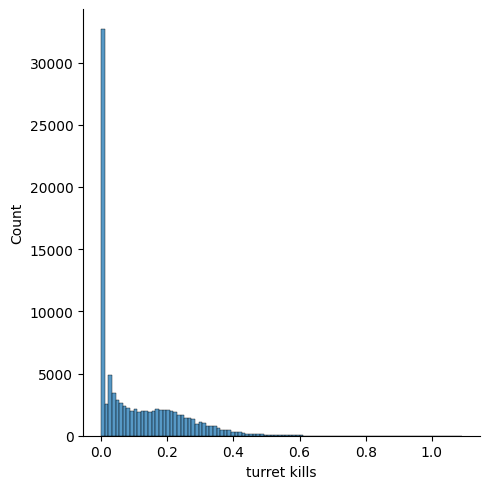

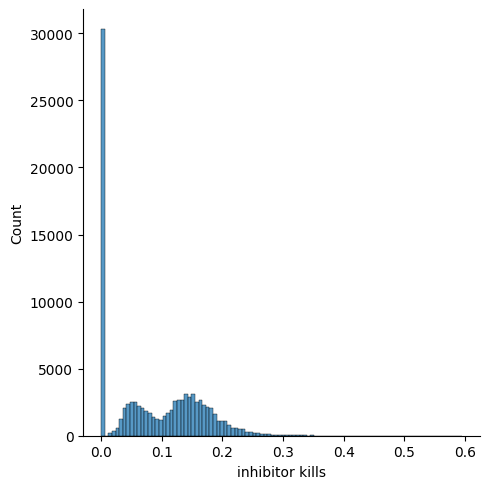

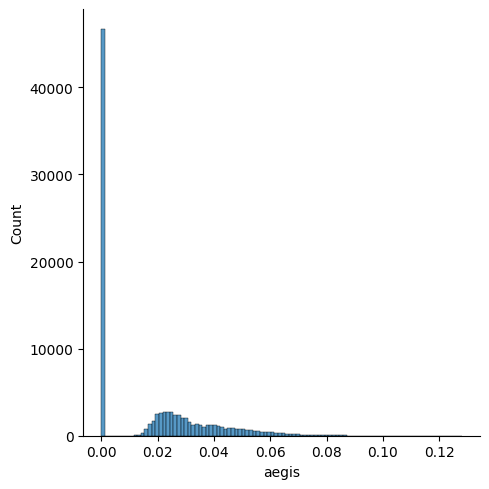

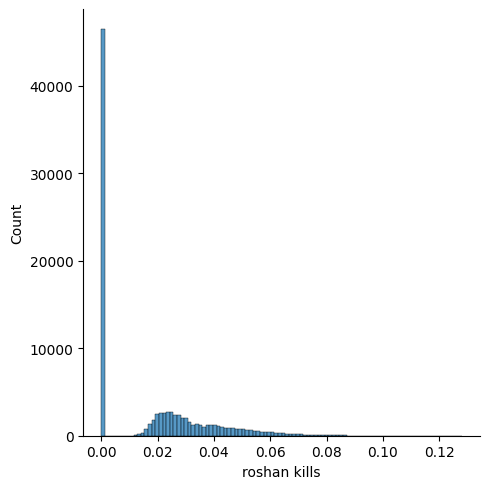

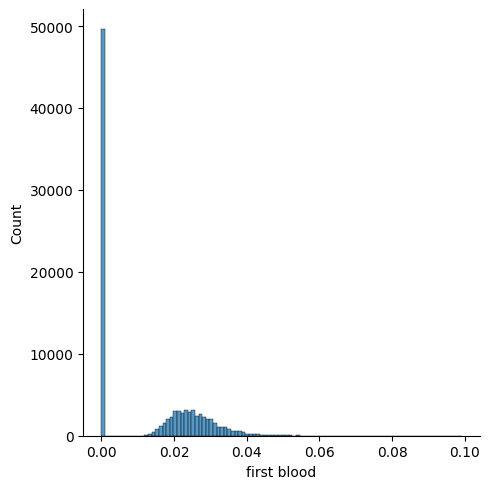

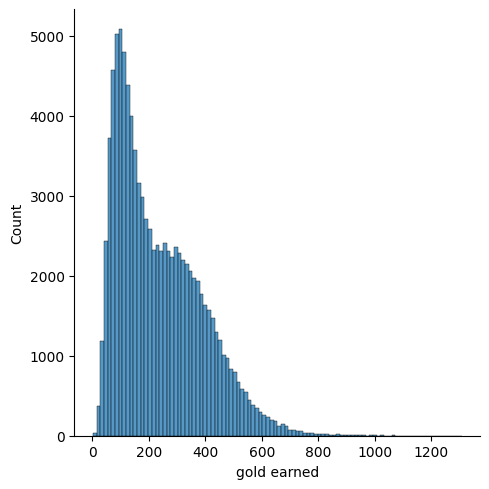

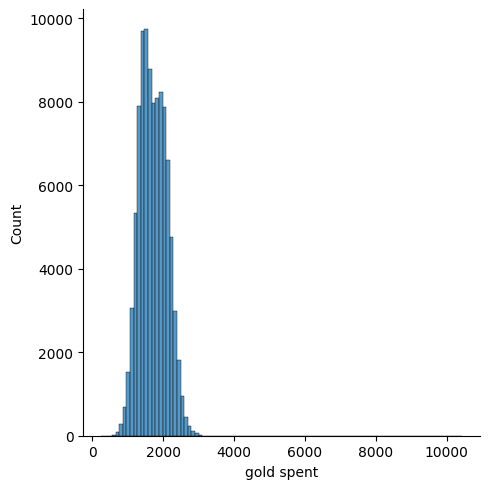

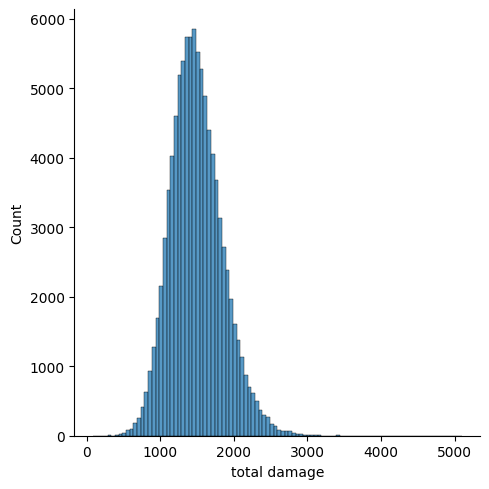

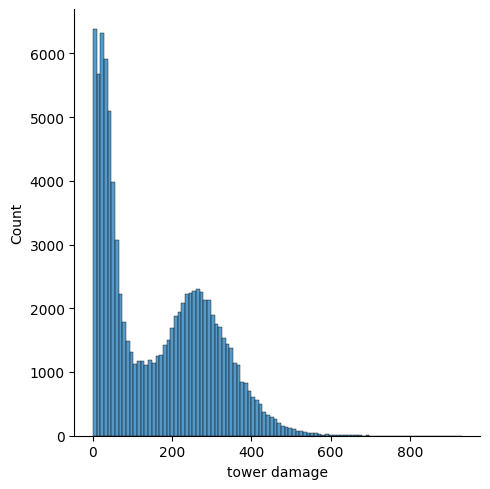

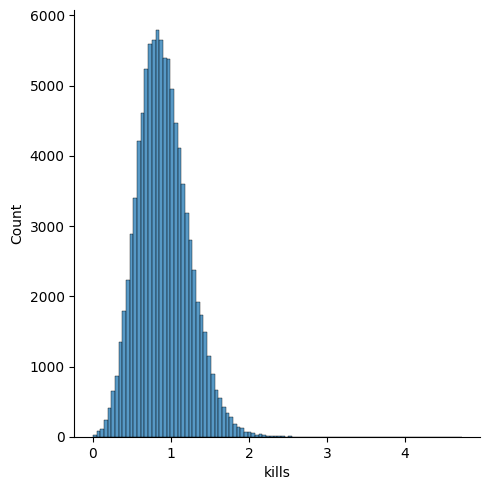

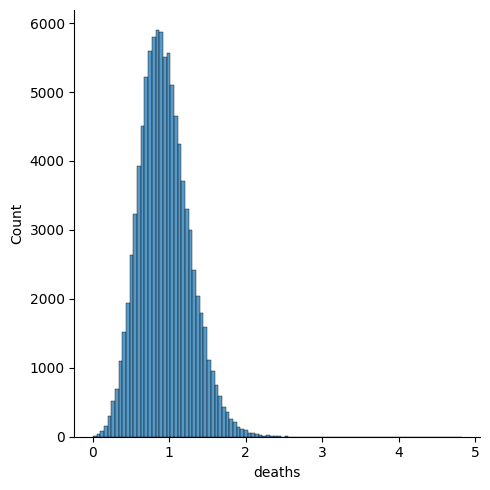

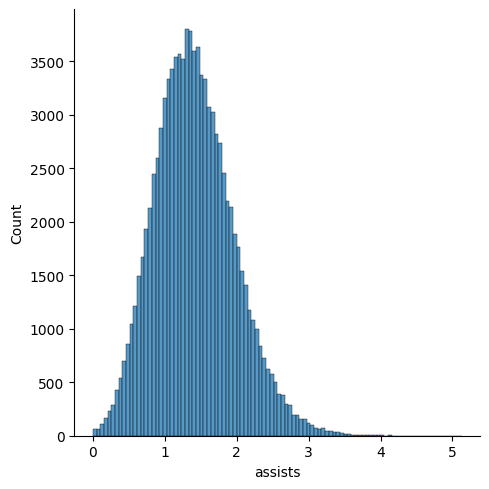

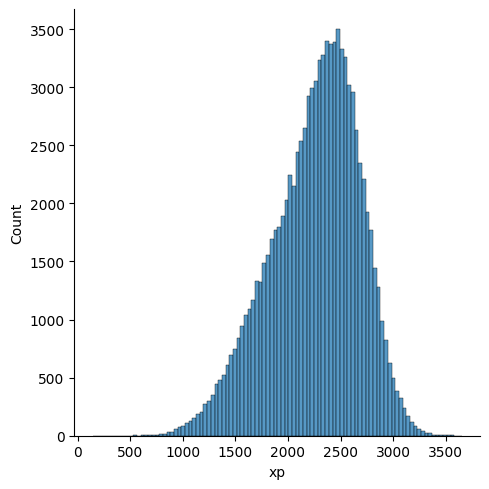

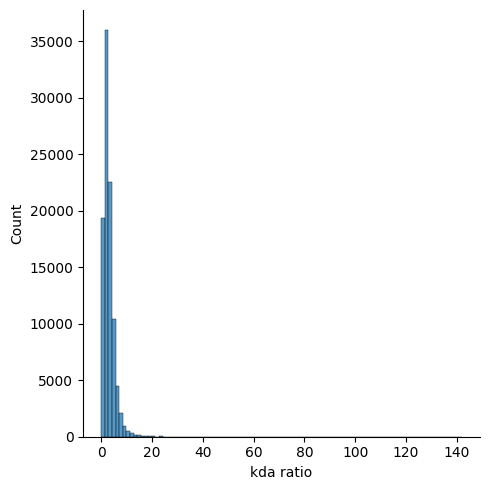

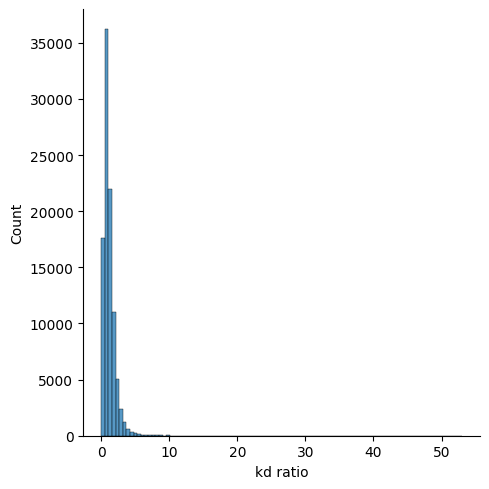

In [12]:
for metric in dota_per_min.columns[2:]:
    sns.displot(dota_per_min, x=metric, bins=100)
    plt.show()

It looks like all of the distributions are what we would expect:

- Some of the variables have a significant number of values at 0 for games where
    - the losing team is stomped, or
    - that end at an early surrender when the victor is clear.

    (Both scenarios are quite common, so we will keep them in.)

- The inhibitor distribution has two peaks, which makes sense because the dota in-game map has three "lanes" by which to enter the enemy base. Destroying inhibitors in a lane creates stronger allied non-player units ("minions") in that lane. In closer games, you will want to destroy inhibitors in multiple lanes to make destroying the enemy base easier. Otherwise, you may be able to win only through a single lane.

- Outside of these two specific scenarios, distributions all appear to be normal.

In [13]:
# Remove major outliers in metrics that intuitively shouldn't have much variation
# (e.g. Roshan being taken more than a couple times is very rare, indicating a
# very exceptional game)
dota_reg = dota_per_min.copy()
print("Number of rows before removing outliers: " + str(dota_per_min.shape[0]))
for field in ["aegis", "roshan kills"]:
    dota_reg = dota_reg[
        (dota_reg[field] <= dota_reg[field].mean() + dota_reg[field].std() * 3)
        & (dota_reg[field] >= dota_reg[field].mean() - dota_reg[field].std() * 3)
    ].reset_index(drop=True)
print("Number of rows after removing outliers: " + str(dota_reg.shape[0]))

Number of rows before removing outliers: 97232
Number of rows after removing outliers: 96245


<a id='scale'></a>
## Scale values to between 0 and 1

In [14]:
dota = dota_reg.copy()
for i in dota.columns[2:]:
    dota[i] = dota[i] / np.nanmax(dota[i])
dota.head()

,match id,winner,turret kills,inhibitor kills,aegis,roshan kills,first blood,gold earned,gold spent,total damage,tower damage,kills,deaths,assists,xp,kda ratio,kd ratio
0,0,True,0.208421,0.254737,0.661474,0.661474,0.254737,0.237186,0.211327,0.422611,0.240343,0.267368,0.089123,0.428770,0.759310,0.056752,0.055494
1,0,False,0.023158,0.084912,0.000000,0.000000,0.000000,0.081570,0.141991,0.233828,0.069228,0.080211,0.272611,0.162637,0.572015,0.006501,0.005443
2,1,False,0.000000,0.000000,0.304222,0.304222,0.234314,0.096382,0.154425,0.267211,0.060431,0.172153,0.255578,0.222131,0.628149,0.011161,0.012460
3,1,True,0.149109,0.234314,0.304222,0.304222,0.000000,0.183339,0.240070,0.425630,0.278384,0.245933,0.178422,0.376262,0.853505,0.025314,0.025497
4,2,False,0.020250,0.074251,0.000000,0.000000,0.000000,0.047847,0.116475,0.199648,0.044773,0.102872,0.224631,0.133598,0.439759,0.007617,0.008471


<a id='check'></a>
# Sanity check

In [15]:
# Check to see how many rows have missing values
print("Number of rows: " + str(dota.shape[0]))
print("Number of rows without null values: " + str(dota.dropna().shape[0]))

Number of rows: 96245
Number of rows without null values: 96245


Every row with a duration has a complete dataset.

In [16]:
dota.describe()

,match id,turret kills,inhibitor kills,aegis,roshan kills,first blood,gold earned,gold spent,total damage,tower damage,kills,deaths,assists,xp,kda ratio,kd ratio
count,96245.000000,96245.000000,96245.000000,96245.000000,96245.000000,96245.000000,96245.000000,96245.000000,96245.000000,96245.000000,96245.000000,96245.000000,96245.000000,96245.000000,96245.000000,96245.000000
mean,24984.091101,0.099370,0.145386,0.226931,0.228653,0.127409,0.204165,0.164158,0.292936,0.175775,0.190962,0.195063,0.276432,0.616763,0.021423,0.022514
std,14433.871401,0.112282,0.129452,0.253946,0.254980,0.139847,0.130696,0.036119,0.069176,0.143608,0.068817,0.067830,0.107317,0.115851,0.017195,0.018961
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001086,0.023653,0.016031,0.000000,0.000000,0.000000,0.000000,0.039157,0.000000,0.000000
25%,12493.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.096024,0.136507,0.245048,0.039795,0.142624,0.147474,0.200702,0.542169,0.011140,0.011586
50%,24975.000000,0.056906,0.130444,0.220028,0.223090,0.000000,0.172742,0.161821,0.287560,0.154437,0.185720,0.189609,0.268955,0.631161,0.017677,0.018156
75%,37467.000000,0.173913,0.249897,0.395121,0.397621,0.248766,0.291645,0.191170,0.335508,0.292010,0.234101,0.237404,0.343610,0.700712,0.027163,0.028302
max,49999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


All the values seem reasonable. Some values being right-skewed (low mean) may lower their weightings in a machine learning setting, but we're just comparing correlations for now.

## Save dataset

In [17]:
dota_csv = dota.copy()
dota_csv["game"] = "dota"
dota_csv.to_csv("../intermediate/dota_clean.csv", index=False)

<a id='correlations'></a>
# Correlation heatmaps

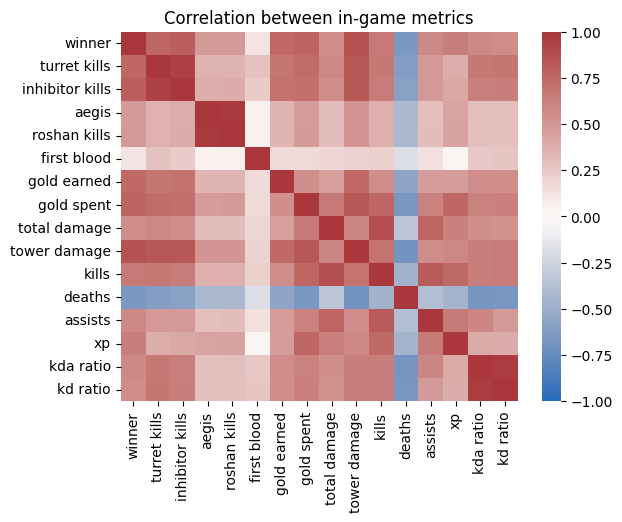

In [18]:
corr_columns = list(dota.columns[1:])
sns.heatmap(dota[corr_columns].corr(), vmin=-1, vmax=1, cmap="vlag").set_title(
    "Correlation between in-game metrics"
)
plt.show()

Deaths are the only heavily negative correlation, so let's try to zoom in on the remaining metrics:

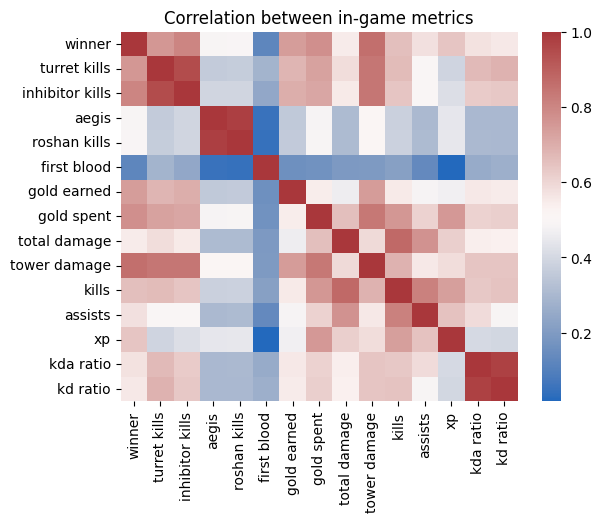

In [19]:
corr_columns.remove("deaths")
sns.heatmap(dota[corr_columns].corr(), cmap="vlag").set_title(
    "Correlation between in-game metrics"
)
plt.show()

Now it's clear that almost all of these variables have a positive correlation to winning the game and to each other.


The correlation heatmaps above clearly show that some variables are highly correlated. For example, the following two objectives are highly correlated:

- **Roshan**, which is a neutral monster that either team can kill to earn a significant amount of gold; and
- the **Aegis**, which is a buff that Roshan drops when killed. Any player on either team can pick up the Aegis to earn signicant numeric bonuses, but it is most likely to be picked up by a member of the team killing Roshan, since they are closer to the buff when it is dropped.

<a id='reg'></a>
# Exploring a prediction model

Purely for exploratory purposes, let's select one objective from each of the visually obvious clusters in the above heatmaps through manual inspection, and then plot how likely they are to predict a win.

In [20]:
prediction_cols = [
    "winner",
    "turret kills",
    "roshan kills",
    "first blood",
    "gold earned",
    "gold spent",
    "kills",
    "deaths",
    "xp",
    "kda ratio",
]

prediction_col_corr = dota[prediction_cols].corr()
print(np.nanmax(np.where(prediction_col_corr == 1, np.NaN, prediction_col_corr)))
prediction_col_corr

0.7742235584895347


,winner,turret kills,roshan kills,first blood,gold earned,gold spent,kills,deaths,xp,kda ratio
winner,1.000000,0.754945,0.490647,0.124400,0.742711,0.774224,0.657517,-0.650542,0.640264,0.571535
turret kills,0.754945,1.000000,0.363885,0.282638,0.680670,0.729746,0.665509,-0.611927,0.389437,0.666542
roshan kills,0.490647,0.363885,1.000000,0.047664,0.356851,0.488497,0.380638,-0.421114,0.447315,0.303274
first blood,0.124400,0.282638,0.047664,1.000000,0.159464,0.165642,0.216657,-0.185017,0.017578,0.254206
gold earned,0.742711,0.680670,0.356851,0.159464,1.000000,0.546260,0.551716,-0.557795,0.470153,0.556321
gold spent,0.774224,0.729746,0.488497,0.165642,0.546260,1.000000,0.757147,-0.660120,0.753152,0.611507
kills,0.657517,0.665509,0.380638,0.216657,0.551716,0.757147,1.000000,-0.463144,0.736675,0.633747
deaths,-0.650542,-0.611927,-0.421114,-0.185017,-0.557795,-0.660120,-0.463144,1.000000,-0.458433,-0.677280
xp,0.640264,0.389437,0.447315,0.017578,0.470153,0.753152,0.736675,-0.458433,1.000000,0.404125
kda ratio,0.571535,0.666542,0.303274,0.254206,0.556321,0.611507,0.633747,-0.677280,0.404125,1.000000


None of these objectives are overly correlated, with the maximum correlation being 0.76.

Purely for exploratory purposes, let's try to create a logistic regression model to predict winning, and see if the highest magnitude coeffficients correspond with the variables that correlate the most with winning.

In [21]:
# Create a log regression model predicting the winner
X = dota[prediction_cols[1:]]
y = dota["winner"]
reg = LogisticRegression(random_state=0).fit(X, y)
reg.score(X, y)

0.9809756350979272

In [22]:
for i in range(X.shape[1]):
    print(prediction_cols[i + 1] + " coefficient: " + str(reg.coef_[0][i]))

turret kills coefficient: 28.238626597799126
roshan kills coefficient: 1.4597442963305276
first blood coefficient: -2.5101942145179246
gold earned coefficient: 21.119663025329366
gold spent coefficient: 20.000521822090633
kills coefficient: 7.418654675817338
deaths coefficient: -16.13495574430404
xp coefficient: 10.87748318301066
kda ratio coefficient: 2.844691617223453


In [23]:
# Table to compare model coefficients with correlations to winning
model_coef = pd.DataFrame(
    {
        "metric": prediction_cols[1:],
        "model_coef": reg.coef_[0],
        "corr": prediction_col_corr.iloc[0, 1:],
    }
).sort_values("model_coef")
model_coef

,metric,model_coef,corr
deaths,deaths,-16.134956,-0.650542
first blood,first blood,-2.510194,0.124400
roshan kills,roshan kills,1.459744,0.490647
kda ratio,kda ratio,2.844692,0.571535
kills,kills,7.418655,0.657517
xp,xp,10.877483,0.640264
gold spent,gold spent,20.000522,0.774224
gold earned,gold earned,21.119663,0.742711
turret kills,turret kills,28.238627,0.754945


While not identical, the rankings for how important a metric is in the model and its correlation to winning definitely seem comparable.

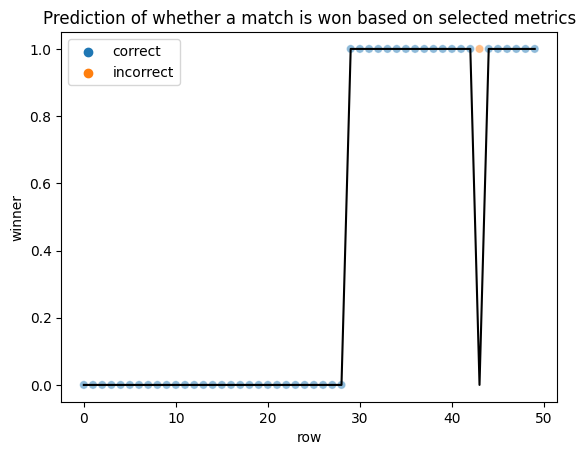

In [24]:
# Add columns for what logreg model predicts
predicted_win = reg.predict_proba(X)[:, 1]
dota_reg_plot = dota.copy()
dota_reg_plot["predicted_win"] = predicted_win > 0.5
dota_reg_plot["predicted_correct"] = np.where(
    dota_reg_plot["predicted_win"] == dota_reg_plot["winner"], "correct", "incorrect"
)

# Select some random rows to plot results on
dota_plot_sample = (
    dota_reg_plot.sample(n=50, random_state=0)
    .sort_values("winner")
    .reset_index(drop=True)
    .reset_index()
    .rename(columns={"index": "row"})
)

dota_plot_sample["winner"] = np.where(dota_plot_sample["winner"], 1, 0)
sns.scatterplot(
    data=dota_plot_sample, x="row", y="winner", hue="predicted_correct", alpha=0.5
).set_title("Prediction of whether a match is won based on selected metrics")
sns.lineplot(data=dota_plot_sample, x="row", y="predicted_win", color="black")
plt.show()